In [1]:
import sys
sys.path.append('..')

In [ ]:
from nx_graph.utils_test import create_trained_model
from nx_graph.utils_test import plot_metrics

In [2]:
from root_gnn import utils_test

In [3]:
from root_gnn import dataset

Welcome to JupyROOT 6.14/08


In [4]:
input_dir = '/global/homes/x/xju/project/xju/gnn_examples/H4l_ggF_vs_VBF/input'
input_data = dataset.dataset(input_dir, 'ggf.root', 'vbf.root', 'tree_incl_all')

In [5]:
n_graphs = 500

In [7]:
import tensorflow as tf

In [8]:
from graph_nets import utils_tf
from graph_nets import utils_np
import os
import networkx as nx
import numpy as np
import pandas as pd

In [10]:
from root_gnn import utils_train
from root_gnn.model import GeneralClassifier

In [11]:
tf.reset_default_graph()
input_graphs, target_graphs = input_data.get_graphs(n_graphs, is_training=False)
input_ph  = utils_tf.placeholders_from_networkxs(input_graphs, force_dynamic_num_graphs=True)
target_ph = utils_tf.placeholders_from_networkxs(target_graphs, force_dynamic_num_graphs=True)

model = GeneralClassifier()
num_processing_steps_tr = 3
output_ops_tr = model(input_ph, num_processing_steps_tr)

In [18]:
loss_ops_tr = utils_train.create_loss_ops(target_ph, output_ops_tr)
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr

In [15]:
output_dir = '../trained_results/try_007'
last_iteration = 2495
ckpt_name = 'checkpoint_{:05d}.ckpt'

In [16]:
sess = tf.Session()
saver = tf.train.Saver()
print("loading checkpoint:", os.path.join(output_dir, ckpt_name.format(last_iteration)))
saver.restore(sess, os.path.join(output_dir, ckpt_name.format(last_iteration)))

loading checkpoint: ../trained_results/try_007/checkpoint_02495.ckpt
INFO:tensorflow:Restoring parameters from ../trained_results/try_007/checkpoint_02495.ckpt


In [24]:
n_batches = 10
all_pred = []
all_target = []
for _ in range(n_batches):
    input_graphs, target_graphs = input_data.get_graphs(n_graphs, is_training=False)
    input_graphs_ntuple = utils_np.networkxs_to_graphs_tuple(input_graphs)
    target_graphs_ntuple = utils_np.networkxs_to_graphs_tuple(target_graphs)

    feed_dict = {
        input_ph: input_graphs_ntuple,
        target_ph: target_graphs_ntuple
    }

    test_values = sess.run({
        "target": target_ph,
        "outputs": output_ops_tr
    }, feed_dict=feed_dict)
    test_pred, test_target = utils_train.eval_output(test_values['target'], test_values['outputs'][-1])
    all_pred.append(test_pred)
    all_target.append(test_target)

In [34]:
test_pred = np.concatenate(all_pred, axis=0)
test_target = np.concatenate(all_target, axis=0)

Accuracy:            0.7816
Precision (purity):  0.7774
Recall (efficiency): 0.7892


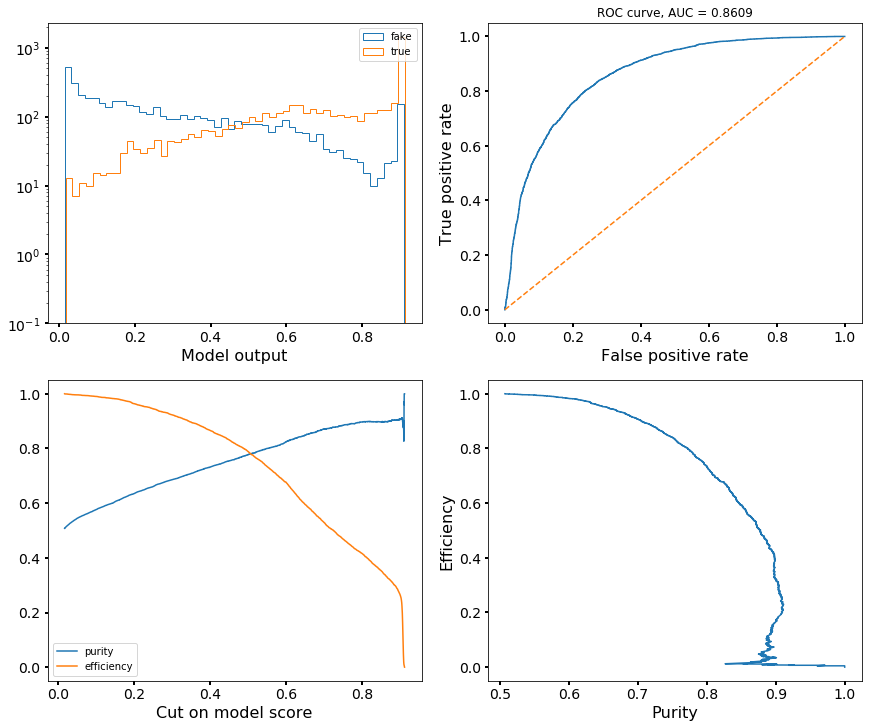

In [35]:
utils_test.plot_metrics(test_pred, test_target, odd_th=0.5)